In [ ]:
from IPython import display

# Q-learning Network

The q-network is parameterized by $w$, given $w$ and a state $s$ the q-network $Q(s, w)$ outputs a vector 
of "q-values" corresponding to scores for each possible action the agent can take in the enviroment. A high "q-value" indicates a action that is more favorable compared to an action with a low "q-value".

The goal is to train the network so that when the agent follow the recommendations (policy) made by the q-network the number of collected yellow bananas will be maximized. 

As part of the training process of the network there are two different stages that repeats it self until the agent is deemed to have solved the enviroment

* **Enviroment Interaction**: The agent interacting with the enviroment following the recommendations made by the q-network

* **Learn**: Updating the q-network using the agent's interactions

In order to facilitate the training of the network we have two sets of weights that parameterize the q-network, $w$ and $w_{\text{target}}$, why that is will be introduced in the "Learn" section.

 
###  Enviroment Interaction

* Choose an action using the q-network's recommendations (policy) after doing inference with the current state using paramters $w$. 
When we start to train the q-network the recommendations are not going to be good (i.e. the network might have been initilzed in such a way that it always outputs approximately the same policy) and we know that we should not trust them. So instead of always following the policy, we are only going to follow it in $1 - \epsilon$ of the times. As the q-networks learns to output good policies, we decrese the $\epsilon$ until we reach $\epsilon_{end}$. Even if the network output good policies it's often favorable to have $\epsilon_{end}$ not equal to zero, making the agent continue to explore the enviroment outside of the network's current understanding about what a good policy might be. 


* As the agent interacts with the enviroment we are continuously producing states $s_t$ actions $a_t$, rewards $r_t$ (that we got after we took the action) and new states $s_{t+1}$ (when we are transitioning from $s_t$ using $a_t$). We call this collection an experience tuple ($s_t$, $a_t$, $r_t$, $s_{t+1}$). This experience tuple is stored in a buffer that is later used when performing the "Learn" step. Together with the experience tuple we also store a measurment of how much novel information that is contained within the tuple, we call this $\text{td-error}$ (it will be defined below). 


###  Learn

* Sample a batch of example from the buffer ($s_t$, $a_t$, $r_t$, $s_{t+1}$) together with the probability ($p_{t}$) of sample each experience tuple in the batch.

* Set a target for the network to learn, $y_t = r_t + \gamma * \text{max}_{a}Q(s_{t+1}, a, w_{\text{target}})$

The target of the action $a_t$ when in state $s_t$ then becomes a weighted sum of the immediate reward (of taking action $a_t$) and the future expected reward, if we follow a greedy policy, expressed by $\text{max}_{a}Q(s_{t+1}, a, w_{\text{target}})$. The discount factor $\gamma$ indicates how important future reward is compared to immediate reward in the target. When we construct the target we use $w_{\text{target}}$ to parametrize the q-network, we do this to stabilize the learning that otherwise might become unstable due to correlations between the target and the network that undergoing learning.

* Create the loss that compares the target with the actual output from the network that undergoes learning 

$$ L = (Q(s_t, a_t, w) - y_t)^2  = (Q(s_t, a_t, w) - (r_t + \gamma * \text{max}_{a}Q(s_{t+1}, a, w_{\text{target}}))^2$$

when we are doing the sampling from the replay buffer each experience tuple has a probability $p_{t}$ of beeing sampled, if all experience tuples have the same probability of beeing sampled $p_{\text{uniform}} = \frac{1}{N}$ where N is the number of tuples in the buffer. In the case when we sample some tuples with higher probability than others (e.g. tuples that holds more novel information) we must compensate, so that we do not insert any bias the learning, for that when constucting the loss. We create a weight $I_t$ that scales all experience tuple's contribution to the loss by comparing the probability of $p_{t}$ with what it would have had if we sampled all tuples uniformly

$$I_{t} = \frac{p_{\text{uniform}}}{p_{t}} = \frac{N}{p_{t}}$$

The loss can thereby be rewritten accordingly, 

$$ L = I_{t}\times(Q(s_t, a_t, w) - y_t)^2$$

During the Enviroment Interaction step, before sending an experience tuple to the replaybuffer we calculate a $\text{td-error}$, it's defined as 

$$\text{td-error} = r_t + \gamma * \text{max}_{a}Q(s_{t+1}, a, w) - Q(s_{t}, a_t, w) $$

and gives an indication about how suprised the network was by getting reward $r_t$ and having the max q-value of the following state. We can then think of $\text{td-error}$ as a proxy for how much novel information the experience tuple holds. During learning we want the network to focus on learning new things, so it makes sense to sample the tuples with high $\text{td-error}$ more frequently than those with low  $\text{td-error}$. In the replaybuffer we then set the probability of sample one tuple to be proportional to it's $\text{td-error}$. This kind of method is called Prioritized Experience Replay.
 
* Update the $q(w)$'s weights by minimization of L using gradient descent. 

* Update the $q(w_{\text{target}})$'s weights by low-pass filter 

$$w_{\text{target}} = \alpha \times w_{\text{target}} + (1 - \alpha) \times w$$

# Network architecture

The network consist of five hidden fully connected layers, seven including the input and output layers. After each layer, except the output layer, layer normalization is used that normalizes the input across the nodes's output. ELU is used as activation function after each layer normalization.
    
    Fully connected - in 37 out 256  -> 256 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 256 out 256 -> 256 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 256 out 128 -> 128 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 128 out 64  -> 64 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 64 out 64   -> 64 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 64 out 32   -> 32 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 32 out 4    -> 4 nodes


In [9]:
#display.Image("img/network_architecture.png")

# Peformance

After 4000 episodes was a score of +13 reached.

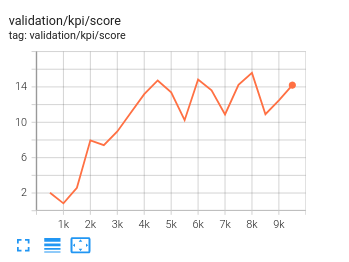

In [2]:
display.Image("img/validation_score.png")

# Hyperparameters 

## Training 

* The number of training iterations = 10000

* The learning-rate used during training of the model lr = 0.001

* The size of the replay buffer, replay_buffer_size = 20000

* The batchsize for each update run, batch_size = 128

* How many consecutive update runs are we going to do before we are producing new entries to the replaybuffer update_steps = 20

* lowpass filter factor that controls the q-learning's targets update speed in terms, copy_weight_scale = 0.0075

## Replay buffer

* Controls the weighing of old tuples to the replay buffer We normalize the weights of the entries in the replay buffer by the number times we have used the tuple to train the model and use sampling_beta as the exponent to that normalizing factor. i.e. sampling_beta -> inf, we only care about new tuples, sampling_beta = 0, we do not care of we have seen the entry many times we will sample the tuples, sampling_beta = 1


## Exploration  vs explotation

* The probability that we will choose one action on random instead of selecting the action with the highest q-value, epsilon=1.0

* Controls how we are decreasing epsilon during training, eps_decay=0.999 

* The final epsilon eps_end = 0.01

* Discount factor in the temporal difference q-learning loss, controls the focus on future vs immediate reward, gamma=0.99


## Evaluation

* How many episodes are we using when evaluating the performance of the model, test_iter = 100

* How frequently are we running a validation-run during training, validation_iter = 500

# Future work

#### Speed up training process

* Implement GPU-support
* Run the batch processing in a seperat thread compared the model inference

#### Fine tuning of hyperparamters
   
* Loop over a grid of hyperparameters, use tensorboard's hyperparamter tracking tool to narrow down a better set of hyperparamters 

#### Using historical state/action information when doing the inference

* Use previous states leading up the agent's current state when doing the model inference. Also, add the actions taken during the previous steps, so that the network can build an internal representation where in the enviroment possible clusters of yellow banans can be found. 
s
#### Using images as as the state representation

* Analyze if using images together with a CNN might lead to a better agent. 

#### Double DQN 

#### Dueling DQN
